# The anisotropy of scattering and Legendre polynomials

In [1]:
name='Pim Nelissen'

## Introduction (and discussion on FAIR principles)

When considering neutron moderation, a typical assumption is the isotropy of scattering in the Center-of-Mass frame. However, there are nuclides for which such an assumption is not accurate. This notebook explores what it means for scattering to be anisotropic, when it occurs, and to map its behaviour.

An attempt has been made to adhere to FAIR principles.

**F (Findable)**: The repository has a `README` and metadata (description, title) on the repository.

**A (Accessible)**: The code is published in a publically available repository.

**I (Interoperable)**: Data is a standard for this field and are taken from the IAEA Nuclear Data Services. It is explained how to find the data, and the code which processes the data is included in the notebook.

**R (Reusable)**: The data files used are shared in the `data` folder.

## Part 1

While discussing slowing down through elastic scattering our main assumption is typically that scattering is isotropic in the Center-of-Mass (CM) frame. Some textbooks, such as [Nuclear Reactor Analysis from Duderstadt and Hamilton](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf) (see page 318) will go one step further and mention (often between lines) that the average scattering cosine in CM can be given as 

$$\bar\mu_c=0.07 A^{2/3} E[MeV]$$

Based on this one expression however it is difficult to imagine how the distribution of $\mu_c$ looks like in case of anisotropy. It is still worth visualizing in which regions this average cosine is less then some threshold (0.1 in this example) to illustrate the energy and nuclide mass range when isotropy is a fairly acceptable assumption. Note however, that assigning a threshold for isotropic behaviour is somewhat arbitrary.

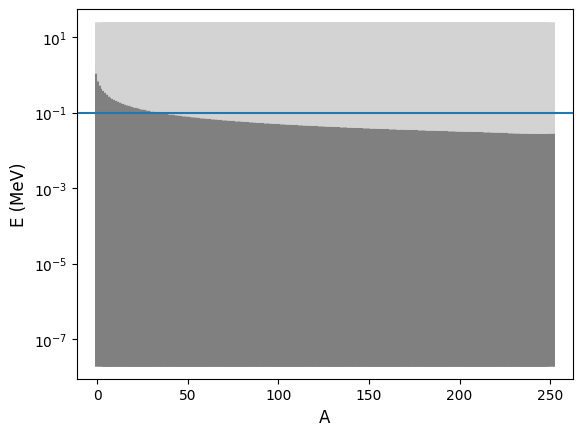

In [2]:
import numpy as np
import matplotlib.pyplot as plt

As=np.linspace(1,250,250)
Es=np.logspace(np.log10(0.025e-6),np.log10(20),1000)

eps=0.1

Avalid=[]
Evalid=[]

Anotvalid=[]
Enotvalid=[]

for A in As:
    for E in Es:
        muc=0.07*A**(2/3)*E
        if abs(muc)<=eps:
            Avalid.append(A)
            Evalid.append(E)
        else:
            Anotvalid.append(A)
            Enotvalid.append(E)
        
plt.figure()
plt.semilogy(Avalid,Evalid,color='gray',marker='x')
plt.semilogy(Anotvalid,Enotvalid,color='lightgray',marker='x')
plt.axhline(0.1)
plt.xlabel('A',fontsize=12)
plt.ylabel('E (MeV)',fontsize=12)
plt.show()        

In the figure, the gray region illustrates the energy-mass number pairs, for which the average cosine is below 0.1, and the light gray regions illustrates the energy-mass number pairs for which the average cosine is above 0.1. It is clear that for heavy nuclei assuming isotropic scattering is above 0.1 MeV neutron energies is not valid.

Also, we have to mention again that from this exercise we have not gained any knowledge about the distribution of the cosine. 

Therefore the goal of this notebook is to review how such distrubition can be be obtained from the raw data files, and how it can be reconstructed. Since the reconstuction of the angular distribution requires the use of the Legendre polynomials, this will allow us to gain further insights into reactor physics methods, which often make use of Legendre polynomials.

We have to note that in this notebook we work with CM data, and when we describe scattering as isotropic or anisotropic, we mean the CM frame. In an [earlier notebook](https://github.com/ezsolti/RFP/blob/master/Datalabs/Datalab04/4-Scattering_MCintro.ipynb) it has already been illustrated that in the laboratory frame (LAB) scattering may be anisotropic even if it is isotropic in the CM frame, espescially for light nuclei such as hydrogen.

### Representing angular distributions

The angular distribution data is stored in file MF=4 of ENDF evaluations. A detailed, and very straightforward description of the format can be found at the [Nuclear information service of LANL T2](https://t2.lanl.gov/nis/endf/intro20.html) (also hit "NEXT" since the next page is also important). Here our intention is to demonstrate how one can reconstruct angular distributions from scratch without relying on nuclear data processing codes.

Angular distributions are given either in tabulated formats, or by Legendre coefficients. In this notebook we are going to look at examples where the distribution is given by coefficients in the center-of-mass frame. In this case the angular distribution can be reconstucted as

$$f(\mu_c,E)=\sum_{l=0}^{NL}\frac{2l+1}{2}\omega_l^c(E)P_l(\mu_c), \: \text{with} \: \omega_0^c\equiv 1$$

where $P_l(\mu_c)$ are the order $l$ [Legendre-polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials), and $\omega_l^c(E)$ are the energy dependent coefficients in the CM. In some textbooks you will find that the definition is slightly different, and the $2l+1$ multiplier is also incorporated in the coefficient.  

If the angular distribution is known, the coefficients can be obtained from

$$\omega_l^c(E)=\int_{-1}^{1}f(\mu_c,E)P_l(\mu_c)d\mu_c \quad (l=0,1,2,...)$$

In reactor physics we love Legendre-polynomials because they can be used to expand a function within the domain $[-1\leq \mu \leq 1]$, and the scattering cosine happens to take values within this domain, therefore angular distributions can be expanded with Legendre polynomials. It has to be mentioned, that in the majority of this notebook we are going to work with angular distributions in CM, however similar Legendre-expansion can be applied for angular distributions in the LAB. Note that throughout this notebook we will refer to CM scattering with sub or superscript "$^c$" and to LAB scattering with sub or superscript "$^0$", superscript for Legendre-coefficients and subscript for angle cosines.

One can use the `eval_legendre` function from the `scipy` package to evaluate the Legendre polynomials. Let us visualize the them.

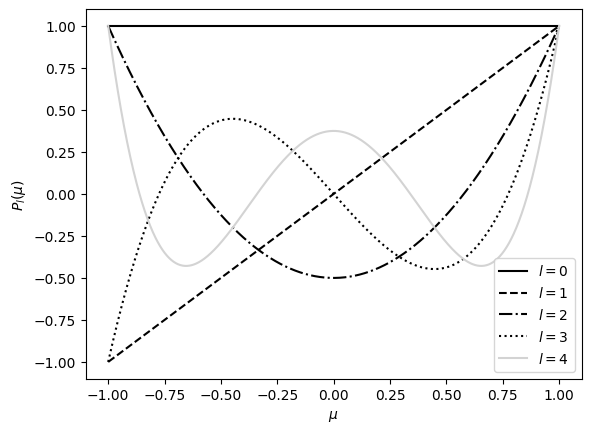

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_legendre

style=['k-','k--','k-.','k:','lightgray']

mu=np.linspace(-1,1,1000)
plt.figure()
for l in range(5):
    plt.plot(mu,eval_legendre(l,mu),style[l],label=r'$l={}$'.format(l))
plt.xlabel('$\\mu$')
plt.ylabel('$P_l(\\mu)$')
plt.legend()
plt.show()

## Legendre coefficients

We are not going to directly parse the ENDF-formatted files since that is a little bit of a headache. Instead one can access from the [IAEA NDS](https://www-nds.iaea.org/) an interpreted format. If one visits NDS, after selecting the target and MF=4 (DA), clicking on "Interpreted" will provide a table (given for the Center-of-Mass system) as below. This example is for H-2 from ENDF-B/VIII.0. Notice that we have truncated the table below, but you can find the same values in the file `data/H2-legendre.dat`. The first column gives the energies and the following columns give the coefficients for $l=1,2,...$ (note that $\omega_0^c=1$, hence not given in the tables).

```
    LTT=3. Part-1:
    Legendre polynomial coefficients given

    Interpolation table:

            341          2                                            

    Angular distribution:

             eV  Coefficients
     ----------  --------------------------------------------------
     1.000000-5  0.000000+0                                                       
     1.000000+2 -9.318808-5 4.139603-9 0.000000+0                                 
     2.000000+2 -1.863621-4 1.626384-8 0.000000+0                                 
     3.000000+2 -2.795222-4 3.637436-8 0.000000+0                                 
     4.000000+2 -3.726684-4 6.447279-8 0.000000+0                                 
     5.000000+2 -4.658003-4 1.008565-7 0.000000+0                                 
     6.000000+2 -5.589182-4 1.452314-7 0.000000+0                                 
     7.000000+2 -6.520216-4 1.975991-7 0.000000+0                                 
     8.000000+2 -7.451109-4 2.582570-7 0.000000+0                                 
     9.000000+2 -8.381860-4 3.266150-7 0.000000+0                                 
     1.000000+3 -9.312468-4 4.032664-7 0.000000+0                                 
     1.900000+3 -1.768135-3 1.455050-6-5.92085-10 0.000000+0                      
     2.800000+3 -2.603811-3 3.157936-6-2.073497-9 0.000000+0                      
     3.700000+3 -3.438233-3 5.510596-6-4.742082-9 0.000000+0                      
     4.600000+3 -4.271359-3 8.511335-6-9.192788-9 0.000000+0                      
     5.500000+3 -5.103148-3 1.215869-5-1.572500-8 0.000000+0                      
     6.400000+3 -5.933558-3 1.645141-5-2.493537-8 0.000000+0                      
     7.300000+3 -6.762548-3 2.138730-5-3.682754-8 0.000000+0                      
     8.200000+3 -7.590076-3 2.696498-5-5.229629-8 0.000000+0                      
     9.100000+3 -8.416101-3 3.318241-5-7.134595-8 0.000000+0                      
     1.000000+4 -9.240581-3 4.003777-5-9.457530-8 2.97407-10 0.000000+0           
     1.400000+4 -1.289158-2 7.821230-5-2.581372-7 5.96160-10 0.000000+0           
     1.800000+4 -1.651634-2 1.288544-4-5.461083-7 1.493732-9 0.000000+0           
     2.200000+4 -2.011459-2 1.918304-4-9.928290-7 3.592867-9 0.000000+0           
     2.600000+4 -2.368609-2 2.670057-4-1.631714-6 6.901327-9 0.000000+0           
     3.000000+4 -2.723058-2 3.542440-4-2.495530-6 1.202810-8 0.000000+0           
     3.400000+4 -3.074781-2 4.534068-4-3.616379-6 1.988843-8 0.000000+0           
     3.800000+4 -3.423753-2 5.643532-4-5.025983-6 3.080091-8 0.000000+0           
     4.200000+4 -3.769951-2 6.869416-4-6.754758-6 4.569137-8-3.02592-10 0.000000+0
     4.600000+4 -4.113350-2 8.210280-4-8.833612-6 6.579576-8-3.03206-10 0.000000+0
     5.000000+4 -4.453926-2 9.664667-4-1.129120-5 9.144767-8-6.07626-10 0.000000+0
     5.500000+4 -4.875714-2 1.164022-3-1.494040-5 1.330946-7-9.13693-10 0.000000+0
     6.000000+4 -5.293043-2 1.378806-3-1.928148-5 1.877621-7-1.526521-9 0.000000+0
     6.500000+4 -5.705871-2 1.610525-3-2.436750-5 2.573730-7-2.142225-9 0.000000+0
     7.000000+4 -6.114162-2 1.858884-3-3.024966-5 3.447849-7-3.067482-9 0.000000+0
     7.500000+4 -6.517878-2 2.123585-3-3.697724-5 4.519543-7-4.304327-9 0.000000+0
     8.000000+4 -6.916984-2 2.404324-3-4.459820-5 5.823908-7-5.854723-9 0.000000+0
     8.500000+4 -7.311443-2 2.700798-3-5.315785-5 7.383936-7-7.720552-9 0.000000+0
     9.000000+4 -7.701222-2 3.012697-3-6.270074-5 9.235124-7-1.021311-8 0.000000+0
     9.500000+4 -8.086288-2 3.339711-3-7.326867-5 1.141009-6-1.333607-8 0.000000+0
     1.000000+5 -8.466609-2 3.681526-3-8.490257-5 1.393542-6-1.709295-8 0.000000+0
     1.100000+5 -9.214095-2 4.408860-3-1.115347-4 2.019348-6-2.746138-8 0.000000+0
     1.200000+5 -9.942885-2 5.191999-3-1.428831-4 2.830047-6-4.198232-8 3.13301-10
                 0.000000+0                                                       
     1.300000+5 -1.065286-1 6.028481-3-1.792126-4 3.856073-6-6.227081-8 3.14499-10
                 0.000000+0                                                       
     1.400000+5 -1.134392-1 6.915825-3-2.207587-4 5.130018-6-8.964590-8 3.15655-10
                 0.000000+0                                                       
```

This format is still not the most straightforward to parse, therefore we have witten some helper functions to do that. Execute the following code block.

In [4]:
def floatify(x):
    """
    Helper function to convert strings containing an "ENDF-number" into float.
    eg.  3.302550-2 to be converted as  0.0330255
        -2.207587-4 to be concerted as -0.0002207587
     
    Parameter
    ---------
    x : str
        Number to be converted as a string. Eg. '3.302550-2'
    """
    if x[0]=='-':
        i=max(x[1:].find('-'), x[1:].find('+'))+1
    else:
        i=max(x.find('-'), x.find('+'))
    return float(x[:i]+'e'+x[i:])

def breakLine(line):
    """
    Helper function to break the lines containing the coefficients in the interpreted table.
    
    Parameter
    ---------
    line : str
        String containing the coefficients
    
    Example
    -------
    >>> breakLine('-9.214095-2 4.408860-3-1.115347-4 2.019348-6-2.746138-8 0.000000+0')
    ['-9.214095-2',
     ' 4.408860-3',
     '-1.115347-4',
     ' 2.019348-6',
     '-2.746138-8',
     ' 0.000000+0']
    """
    values=[]
    segment=line[0:11]
    i=1
    while len(segment)>2:
        if segment[2]!=' ':
            values.append(segment)
        segment=line[i*11:i*11+11]
        i+=1
    return values

def coefficientReader(filename):
    """
    Function to read the coefficients from a file. The file is expacted to have the same 
    format as the interpreted tables from IAEA-NDS, without the header information.
    
    Parameters
    ----------
    filename : str
        The name of the file storing the interpreted table
    """
    import textwrap
    E=[]
    coeffs=[]
    file=open(filename,'r').readlines()
    coeff=[]
    for line in file:
        x=line.strip().split()
        xc=breakLine(line[12:])
        if line[1].isdigit():
            if len(E)!= 0:
                coeffs.append(coeff)
                coeff=[]
            E.append(floatify(x[0]))
            for ci in xc: coeff.append(floatify(ci))
        else: 
            for ci in xc: coeff.append(floatify(ci))
    if len(coeff) != 0: coeffs.append(coeff)
    maxN=max([len(c) for c in coeffs])
    coeffsN=np.zeros((len(E),maxN))
    for i,c in enumerate(coeffs):
        for j,cj in enumerate(c):
            coeffsN[i,j]=cj
    return np.array(E),coeffsN

So let us read the data for Deuterium. The function `coefficientReader` returns an array containing the energies for which the coefficient is given, and a matrix containing the coefficients (the matrix has as many rows as the length of the energy array, and as many columns as the distribution given with the highest Legendre orders).

Let's try to visualize the coefficients.

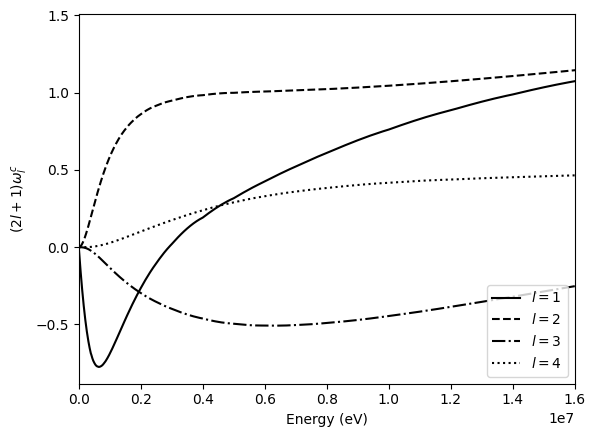

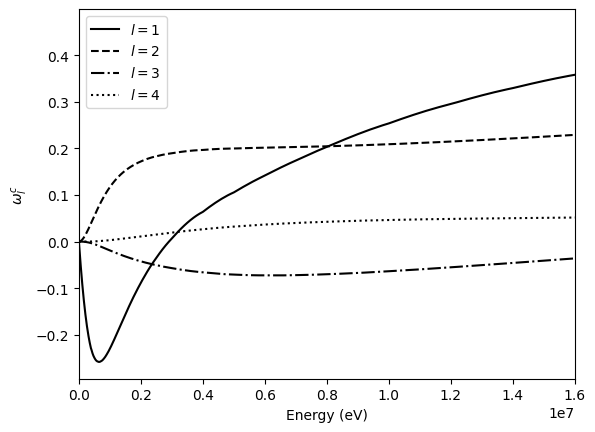

In [5]:
E,coeffs=coefficientReader('data/H2_legendre.dat')

style=['k-','k--','k-.','k:','lightgray']

plt.figure()
for i in range(4):
    plt.plot(E,(2*(i+1)+1)*coeffs[:,i],style[i],label='$l={}$'.format(i+1)) #2l+1 multiplier in the coefficient!
plt.xlabel('Energy (eV)')
plt.ylabel(r'$(2l+1)\omega_l^c$')
plt.xlim(0,16e6)
plt.legend()
plt.show()

plt.figure()
for i in range(4):
    plt.plot(E,coeffs[:,i],style[i],label='$l={}$'.format(i+1))
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\omega_l^c$')
plt.xlim(0,16e6)
plt.legend()
plt.show()


Let us investigate the coefficients for an other nuclide as well, Iron-55. We have also downloaded the coefficients for this nuclide, and are places into 'data/Fe55_legendre.dat'.

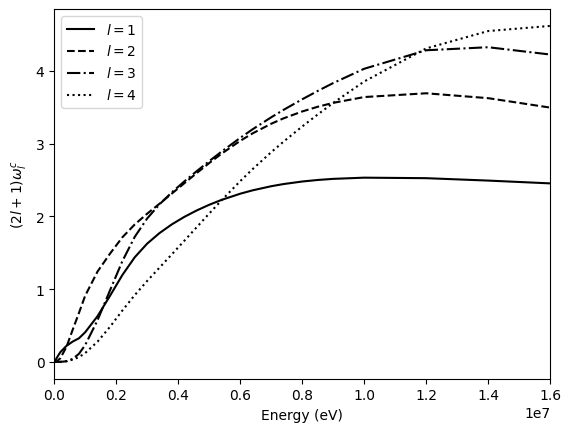

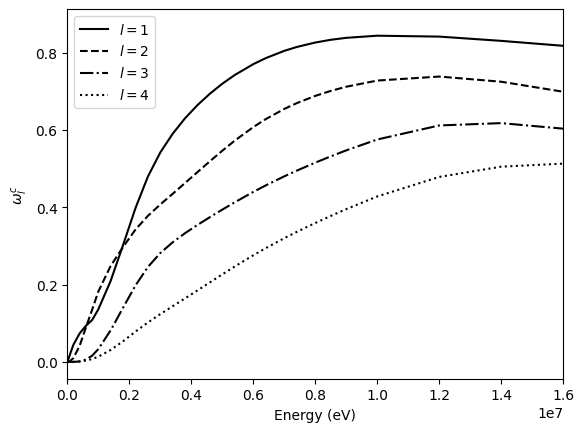

In [6]:
E,coeffs=coefficientReader('data/Fe55_legendre.dat')

style=['k-','k--','k-.','k:','lightgray']

plt.figure()
for i in range(4):
    plt.plot(E,(2*(i+1)+1)*coeffs[:,i],style[i],label='$l={}$'.format(i+1)) #2l+1 multiplier in the coefficient!
plt.xlabel('Energy (eV)')
plt.ylabel(r'$(2l+1)\omega_l^c$')
plt.xlim(0,16e6)
plt.legend()
plt.show()

plt.figure()
for i in range(4):
    plt.plot(E,coeffs[:,i],style[i],label='$l={}$'.format(i+1))
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\omega_l^c$')
plt.xlim(0,16e6)
plt.legend()
plt.show()

What is your conclusion? In terms of isotropy for higher than 1 MeV neutron energies? Is $\bar\mu_c$ typically positive or negative?

> **Conclusion:** For Deuterium, we see that some of the coefficients actually are negative ($\omega_{1,3}^c$). So there is actually some backward scattering bias. As we go above 1 MeV, the overall contribution from all coefficients seems positive. With Fe-55, the story is different. Above 1 MeV there is only forward bias, and the magnitude of the coefficients is also higher than with Deuterium. Again, overall $\bar\mu_c$ seems positive like with Deuterium. At least our approximation in the beginning, $\bar\mu_c = 0.07A^{2/3}E$ captures this, since it is strictly positive and growing with energy, so even if not all coefficients are always positive, $\bar\mu_c$ seems to be for Deuterium and Fe-55.

### Reconstructing the angular distribution

We are familiar now with the Legendre polynomials and with the coefficients, so let's reconstruct the distribution. We are going to do this for yet an other nuclide, Cu-63, mostly because its distribution will show some interesting structure, and because we can compare it with the results at LANL's T2. The data is in file `data/Cu63_legendre.dat`, and is accessed from ENDF/B-VIII.

We have implemented parts of `reconstructAngularDistribution()` to perform the reconstruction. The function has an option to plot (if parameter `plot=True`) the distribution and its components. If parameter `single=True`, the components are plotted, otherwise the sum of the components up to the given order are plotted (ie. with this option one is able to see how the distribution converges to its final shape by adding higher and higher orders). Let's define this function.

In [7]:
def reconstructAngularDistribution(coeffs,N=100,plot=False,single=False,out=None):
    """
    Function to reconstruct angular distribution from the coefficients.
    
    Parameters
    ----------
    coeffs : list
        List of Legendre coefficient in increasing order
    N : int
        Number of cosine values where the distribution is evaluated at. Default: N=100
    plot : bool
        Option for plotting. If True the angular distribution is visualized. Default: plot=False
    single : bool
        Option for plotting. If True, the various orders is plotted. If false, the sum of the various
        orders is plotted. Default: single=False.
    """
    from scipy.special import eval_legendre
    mu=np.linspace(-1,1,N)
    f=np.ones(N)*0.5  #omega_0^c=1, therefore (2l+1)/2*omega=1/2
    if plot:
    #    plt.figure()
        plt.plot(mu,f,label='$l=0$')
    for li,cf in enumerate(coeffs):
        if li == 0:
            continue
        term = ((2*li+1)/2 * cf * eval_legendre(li, mu))
        f += term
        
        if plot and cf != 0.: #do not plot for coefficients which are zero.
            if single:
                plt.plot(mu, term, label=f'$l={li}$')
            else:
                plt.plot(mu, f, label=f'$l={li}$')
    if plot:
        plt.plot(mu,f,'k',lw=2,label='total')
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('$\\mu_c$')
        plt.ylabel('Angular distribution')
        if out is not None:
            plt.savefig(out,dpi=300)
        plt.show()
    return mu,f

And now we will test it at E=1.8 MeV. This is the 70th row (with python indexing) in the list of coefficients.

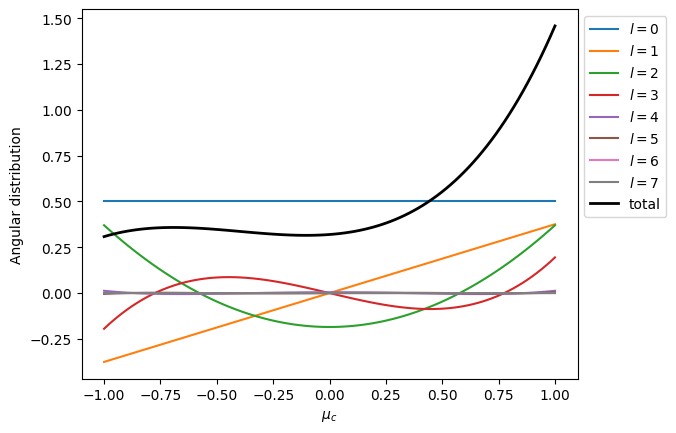

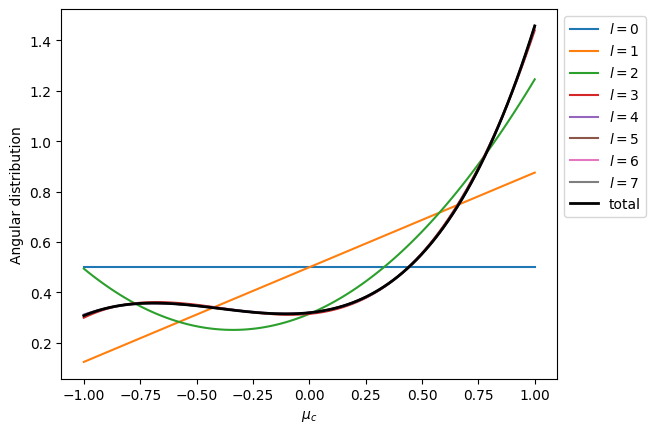

In [8]:
E,coeffs=coefficientReader('data/Cu63_legendre.dat')

_,_=reconstructAngularDistribution(coeffs[70,:],plot=True,single=True)
_,_=reconstructAngularDistribution(coeffs[70,:],plot=True)

Conclude how many orders could we disregard to arrive to a reasonable distribution? In many applications we consider a linearly isotropic distribution, does it seem as a good choice?

> **Conclusion:** A linear approximation would certainly not be appropriate here, since we have a local minimum at ~$\mu_c = 0$ which would not be captured by a linear function. An approximation using up to the third order seem to give a distribution that actually captures the shape of the total one including all 8 of the orders, so the 4 highest orders could be disregarded.

### Energy dependence of the angular distribution

We have studied the energy dependence of the coefficients and the shape of the angular distribution. Now we will visualize how the angular distribution depends on the incident energy of the neutron.

For this we will create an "NJOY-like" plot as in the T2 page (NJOY is a nuclear data processing code widely used for similar tasks). We will visualize the angular distribution at 17 energies. The plot is based on the code at [Matplotlib's documentation on polys3d](https://matplotlib.org/3.1.1/gallery/mplot3d/polys3d.html). Everything is already written, you just need to execute the cell. It does depend however on function `reconstructAngularDistribution()`, so make sure that you have not altered the `return` statement of that.

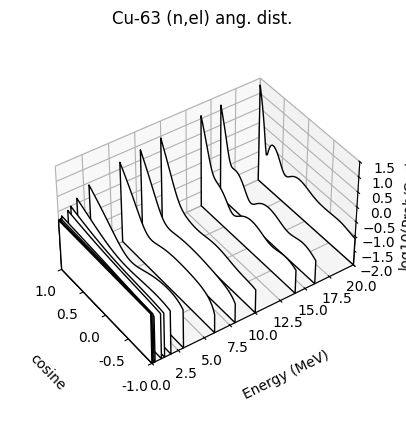

In [9]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

def polygon_under_graph(xlist, ylist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], -2.), *zip(xlist, ylist), (xlist[-1], -2.)] #here 0.0 is changed from original code to
                                                                   #-2.0 to modify reference level


fig = plt.figure(figsize=(20,5))
### NOTE: this line does not work for me on matplotlib==3.10.3, which is a rather recent version
# ax = fig.gca(projection='3d')

# this works with my version
ax = fig.add_subplot(projection='3d')

# Make verts a list, verts[i] will be a list of (x,y) pairs defining polygon i
verts = []

# Set up the x sequence
xs = np.linspace(-1, 1, 100)

# The ith polygon will appear on the plane y = zs[i]
indices=[0,3,7,10,20,40,60,64,67,70,72,75,77,79,83,85,89] #index for some of the energies to include
zs=[E[i]/1e6 for i in indices]

for i in indices:
    mu,f=reconstructAngularDistribution(coeffs[i]) #reconstract angular distribution at a given energy
    ys = np.log10(f)                               #we will plot in a log scale
    verts.append(polygon_under_graph(-xs, ys))

poly = PolyCollection(verts, facecolors=['white' for _ in indices],edgecolors=['black' for _ in indices])
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('cosine')
ax.set_ylabel('Energy (MeV)')
ax.set_zlabel('log10(Prob/Cos)')
ax.set_xlim(-1, 1)
ax.set_xticks([-1.0,-0.5,0.0,0.5,1.0])
ax.set_xticklabels(['1.0','0.5','0.0','-0.5','-1.0']) #we need to swap the labels
                                                      #since we introduced a '-xs' above. 
                                                      #This is just for aesthetics
ax.set_ylim(0, 20)
ax.set_zlim(-2, 1.5)

ax.azim = -35
ax.elev = 41

x_scale=1
y_scale=1.5
z_scale=1.1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 25
plt.title('Cu-63 (n,el) ang. dist.')
plt.show()

Since the [LANL T2](https://t2.lanl.gov/nis/endf/intro20.html) site provides a very nice explanation on the shapes we can observe, here the same explanation is quoted:

> At low energies for elastic scattering, the angular distribution will be isotropic in the center of mass reference frame. As the energy increases, the scattering typically becomes more and more forward peaked, and higher and higher Legendre orders will be needed. If the energy goes through a resonance, dramatic swings from forward scattering to backward scattering may be seen. At the highest energies, the scattering is basically the diffraction of a wave around a hard sphere, and the results are similar to diffraction patterns for light. The forward peak is like the bright central spot in a diffraction pattern, and the oscillations at larger angles are analogous to the fringes seen for light.

## Part II

### Comments on slowing down due to anisotropy

When discussing neutron transport theory, we might recall that scattering is taken into account through the double differential cross section $$\Sigma_s(E'\rightarrow E, \mu_0)$$ where $\mu_0$ is the scattering cosine in LAB. However most often we can assume that the scattering kernel does not depend separately on the energy and the angular variable. We can recall the relationship between energy in LAB before and after the event and scattering cosine in the CM: $$E_l'=\frac{1}{2}E_l[(1+\alpha)+(1-\alpha)\mu_c]$$

Thus sampling the cosine according to the angular distributions studied here can be used to determine the energy after the scattering reaction.

We also have to highlight that as discussed in an [earlier notebook](https://github.com/ezsolti/RFP/blob/master/Datalabs/Datalab04/4-Scattering_MCintro.ipynb), scattering is typically anisotropic in the LAB, even if scattering is isotropic in CM. The conversion for the scattering cosine from CM to LAB can be given as:

$$\mu_0=\frac{A\mu_c+1}{\sqrt{A^2+2A\mu_c+1}}$$

Let's evaluate this relationship:

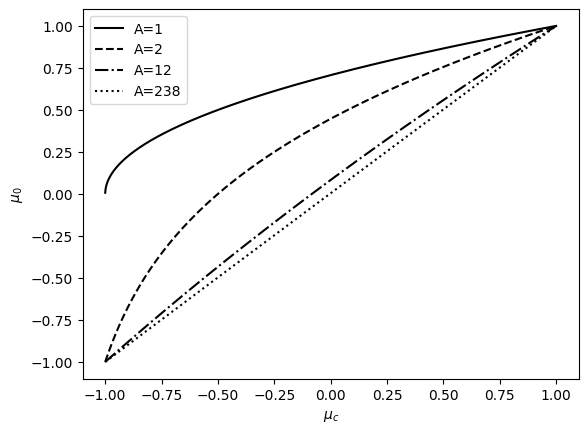

In [10]:
muc=np.linspace(-0.9999,1,1000) #low boundary at -0.9999 to avoid dividing with zero for A=1
style=['-','--','-.',':']
plt.figure()
for i,A in enumerate([1,2,12,238]):
    mul=(A*muc+1)/np.sqrt(A**2+2*A*muc+1)
    plt.plot(muc,mul,'k'+style[i],label='A={}'.format(A))
plt.legend()
plt.xlabel('$\\mu_c$')
plt.ylabel('$\\mu_0$')
plt.show()

One can clearly notice that the LAB scattering is going to be anisotropic (as we have already observed). This is espescially true for Hydrogen, for which one will always observe forward scattering.


### Task

Finally, you will investigate how neutrons loose energy in scattering if it is anisotropic in CM. Let's consider for simplicity that scattering is linearly anisotropic:

$$f(\mu_c)=\frac{1+3\bar\mu_c\mu_c}{2}$$

where $\bar\mu_c$ is the average of the cosine in CM. One can see from the Legendre-expansion above that in fact $\bar\mu_c=\omega_1^c$. Also from the figures showing the energy-dependence of the Legendre coefficients, we could notice that usually $\omega_1^c$ is a positive value.

Instead of doing the math (although you are encouraged to do it and compare it with your numeric results), let us try a Monte Carlo experiment and sample scattering cosines according to this distribution, then study the ratio of energies before and after the scattering to evaluate the logarithmic slowing down decrement ($\xi=\overline{\ln\big(\frac{E}{E'}\big)}$, the average of the logarithm of the ratio).

The distribution has the following shape:

$$p(\nu)=c^{-1}(c_0+c_1\nu)$$ within some domain $(a,b)$, and $c_1 \neq 0$, $c=(b-a)[c_0+(c_1/2)(b+a)]$. We can find this distribution in the the [Monte Carlo sampler](https://mcnp.lanl.gov/pdf_files/la-9721.pdf) <span style="color: red;">[Note: URL not found. [This](https://mcnp-green.lanl.gov/pdf_files/TechReport_1983_LANL_LA-9721-MS_EverettCashwell.pdf) seems to work.]</span> as rule C12 (see p61). If $c_1>0$ (thus $\omega_1^c>0$):

$$\nu=a+max\Big\{(b-a)r_1,\: (b+a+2c_0c_1^{-1})r_2-2(a+c_0c_1^{-1})\Big\}$$

where $r_1$ and $r_2$ are uniform random numbers between 0 and 1. Implemented this sampler for our linearly anisotropic distribution as `sampleLinear()`. Then visually test whether the sampler works as intended (hint: you can renormalize a histrogram of sampled values to get an empirical probability density function).

In [11]:
def sampleLinear(mubar,N=1):
    """
    Function to sample a linear distribution given with
    p(x)=(c0+c1*x)/c; x in (a,b), c=(b-a)*(c0+(c1/2)*(b+a))
    for c1>0.
    
    This sampler can be found as rule C12 in LA-9721-MS.
    
    Parameters
    ----------
    mubar : float
        Average cosine in CM
    N : int
        Number of samples to be drawn
    
    Note
    ----
    The function does not need to be a general implementation in the sense that a,b,c0 might be hard coded to represent
    the linearly anisotropic probability density function.
    """

    # since x \in (a,b), and we are sampling \mu_c we have that:
    a = -1
    b =  1
    
    # and with linear anisotropy formula described above, we have
    c_0 = 1/2
    c_1 = 3*mubar/2

    # MC algorithm:
    result = np.zeros(N)
    for i in range(N):
        r_1, r_2 = np.random.rand(2)
    
        p = (b-a)*r_1 # first term in max()
        q = (b+a+2*c_0/c_1)*r_2 - 2*(a+c_0/c_1) # second term in max()
        
        nu = a + max(p, q)
        result[i] = nu

    return result

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_74095/3669534454.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f"Emperical PDF for scattering angle in CM, $\\bar\mu_c=${muC_test}")


Text(0, 0.5, 'Probability density')

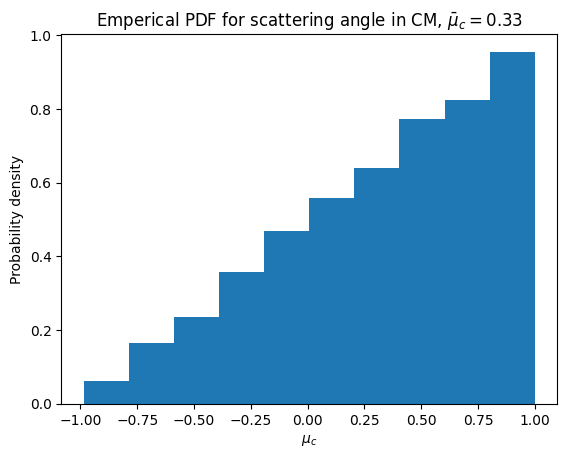

In [12]:
muC_test = 0.33
result = sampleLinear(muC_test, N=10_000)
plt.title(f"Emperical PDF for scattering angle in CM, $\\bar\mu_c=${muC_test}")
plt.hist(result, density=True)
plt.xlabel("$\\mu_c$")
plt.ylabel("Probability density")

Now you will investigate the impact of anisotropy in the CM on the scattering. Use your `sampleLinear()` function to study the average cosine in LAB ($\bar\mu_0$), the logarithmic decrement ($\bar\xi$). Compare it with simulations you perform with assuming an isotropic CM scattering. Perform this for various mass numbers (eg. $A=2,12,238$), tabulate and conclude your results. Is elastic scattering more or less efficient at high energies where anisotropy is present? Is there some other reaction which might compensate the changed efficiency of elastic scattering at this energies?

> Let's set up some functions which will be needed later.

In [13]:
def calculate_mubarC(E, A):
    return 0.07 * A**(2/3) * E/1e6

def cm_to_lab(muC, A):
    muL=(A*muC+1)/np.sqrt(A**2+2*A*muC+1)
    return muL

def energy_after_scattering(E, A, muC):
    alpha= ( (A-1) / (A+1) ) ** 2
    E_after = E/2 * ((1+alpha) + (1-alpha) * muC)
    return E_after

def logarithmic_decrement(E, E_after):
    return np.log(E/E_after)

> Now, let's create an energy space and write some MC simulations for sampling both isotropic and anisotropic scattering in CM, and immediately use those simulation results to calculate the mean scattering angle in LAB as well as the logarithmic decrement.

In [14]:
E_vals = np.linspace(1, 16e6, 100)
A_list = [2, 12, 238]

def sim_iso_scattering(E, A, N=10_000):
    muC=np.random.uniform(-1,1,N)
    mu0 = cm_to_lab(muC, A)
        
    E_after = energy_after_scattering(E, A, muC)
    xi = logarithmic_decrement(E, E_after)

    mubar0 = np.mean(mu0)
    xibar = np.mean(xi)

    return mubar0, xibar
    
def sim_aniso_scattering(E, A, N=10_000):
    mubarC = calculate_mubarC(E, A)
    muC = sampleLinear(mubarC, N=N)
    mu0 = cm_to_lab(muC, A)
    
    E_after = energy_after_scattering(E, A, muC)
    xi = logarithmic_decrement(E, E_after)

    mubar0 = np.mean(mu0)
    xibar = np.mean(xi)

    return mubar0, xibar

results = []

for j, A in enumerate(A_list):
    for i, E in enumerate(E_vals):
        mubar0_iso, xibar_iso = sim_iso_scattering(E, A)
        mubar0_aniso, xibar_aniso = sim_aniso_scattering(E, A)
        # append in dict format for later DataFrame usage
        results.append({
            'A': A, 'E [MeV]': E/1e6,
            '$\\bar\\mu^{iso}$': mubar0_iso, '$\\bar\\mu^{aniso}$': mubar0_aniso,
            '$\\bar\\xi^{iso}$': xibar_iso, '$\\bar\\xi^{aniso}$': xibar_aniso})

In [15]:
import pandas as pd
df = pd.DataFrame(results)

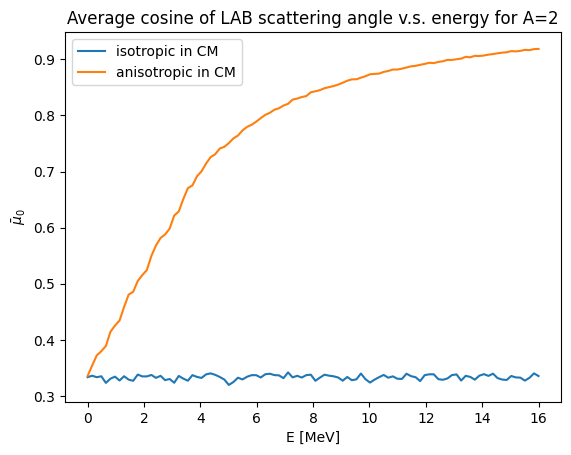

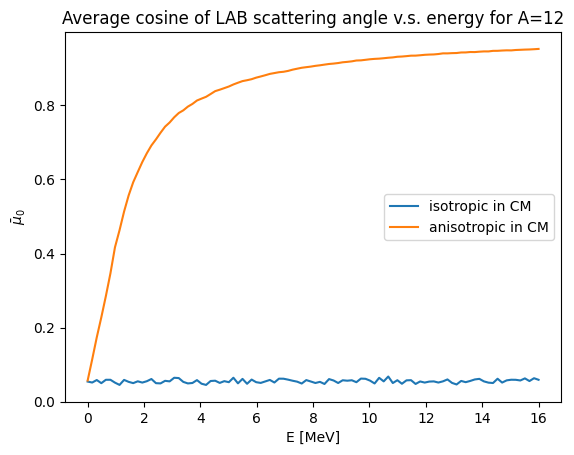

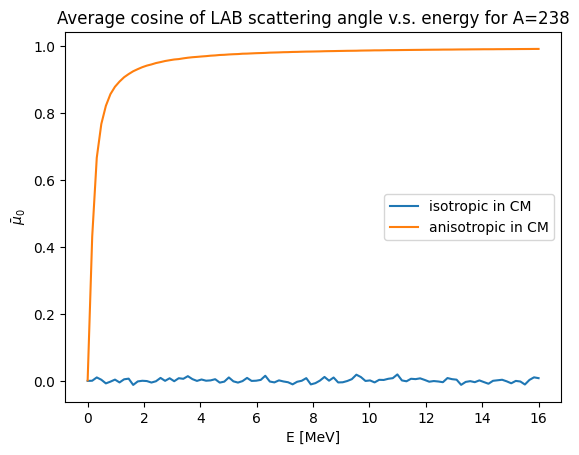

In [16]:
for A in A_list:
    plt.figure()
    
    plt.plot(
        df[df['A'] == A]['E [MeV]'],
        df[df['A'] == A]['$\\bar\\mu^{iso}$'],
        label="isotropic in CM"
    )
    
    plt.plot(
        df[df['A'] == A]['E [MeV]'],
        df[df['A'] == A]['$\\bar\\mu^{aniso}$'],
        label="anisotropic in CM"
    )

    plt.legend()
    plt.title(f"Average cosine of LAB scattering angle v.s. energy for A={A}")
    plt.xlabel("E [MeV]")
    plt.ylabel("$\\bar\\mu_0$")

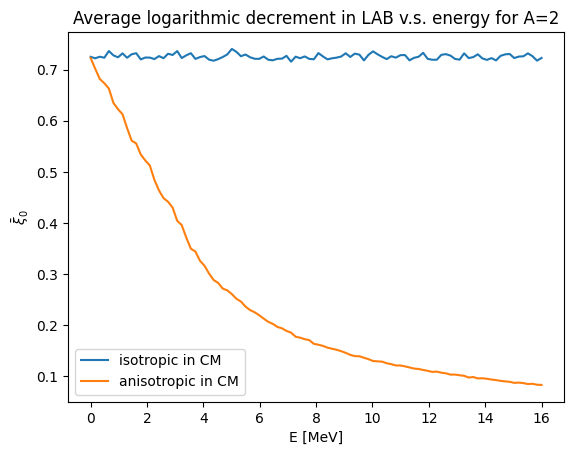

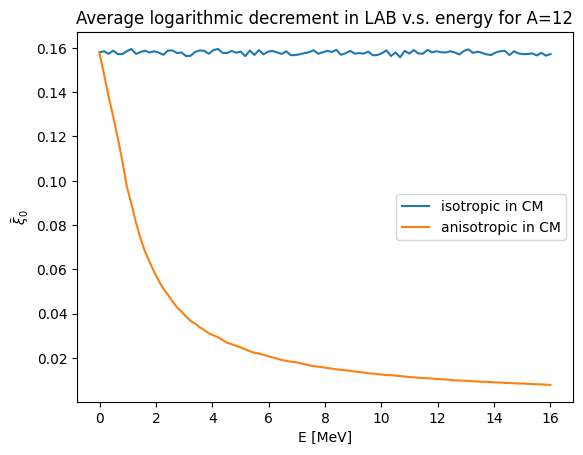

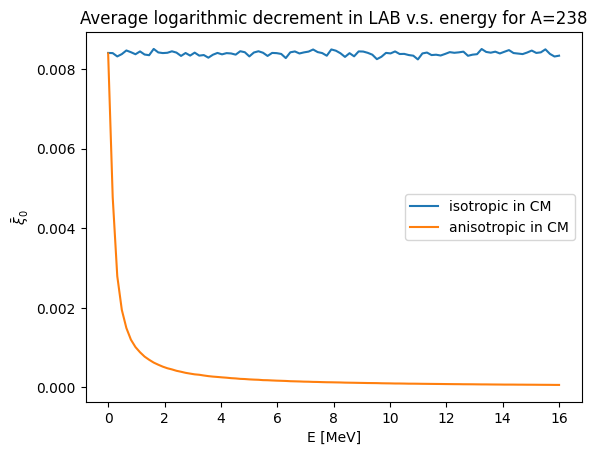

In [17]:
for A in A_list:    
    plt.figure()
    
    plt.plot(
        df[df['A'] == A]['E [MeV]'],
        df[df['A'] == A]['$\\bar\\xi^{iso}$'],
        label="isotropic in CM"
    )
    
    plt.plot(
        df[df['A'] == A]['E [MeV]'],
        df[df['A'] == A]['$\\bar\\xi^{aniso}$'],
        label="anisotropic in CM"
    )

    plt.title(f"Average logarithmic decrement in LAB v.s. energy for A={A}")
    plt.legend()
    plt.xlabel("E [MeV]")
    plt.ylabel("$\\bar\\xi_0$")

> Let's tabulate some values:

In [18]:
# We don't have nice numbers in our energy linspace. Let's find the closest values to these energies:
target = [1e-6, 1, 10] # MeV

col = df["E [MeV]"].values # list values
closest_values = [col[np.abs(col - t).argmin()] for t in target] # find closest values by minimal absolute difference
selection = df[df["E [MeV]"].isin(closest_values)] # select only the rows where we have those closest values
selection.sort_values(by=["E [MeV]", "A"], ascending=[True, True]) # sort by E, then A

A    E [MeV]  $\bar\mu^{iso}$  $\bar\mu^{aniso}$  $\bar\xi^{iso}$  \
0      2   0.000001         0.333397           0.335640         0.725218   
100   12   0.000001         0.054135           0.056978         0.158007   
200  238   0.000001         0.000446           0.002112         0.008400   
6      2   0.969698         0.334282           0.425347         0.724347   
106   12   0.969698         0.051233           0.417031         0.158491   
206  238   0.969698         0.004339           0.879327         0.008367   
62     2  10.020202         0.323726           0.873400         0.736011   
162   12  10.020202         0.056704           0.924754         0.157577   
262  238  10.020202         0.001882           0.987779         0.008388   

     $\bar\xi^{aniso}$  
0             0.722819  
100           0.157532  
200           0.008386  
6             0.622757  
106           0.097356  
206           0.001014  
62            0.129416  
162           0.012545  
262           0.000103

> First, some observations from the plots. We can clearly see the deviation in LAB observations when comparing isotropic and anisotropic scattering in CM. While both are anistropic for low $A$, the isotropic CM assumption results in $\bar\mu_0$ tending to $0$, which would indicate isotropy in LAB for heavier elements. But, when we account for anisotropy in CM, the relation between cosine of the angle and energy is drastically different. We get more like an asymptotic approach towards $\bar\mu_0 = 1$, meaning that with increasing energy there is more of a forward bias. This even seems to be so for the lighter elements. As the mass number increases, $\bar\mu_0$ for anisotropic CM seems to approach $1$ quicker. Considering that on top of the fact that with isotropic CM the anisotropy in LAB disappears for higher mass numbers, it becomes clear that anisotropic scattering in CM could be important for accurate modelling in nuclear reactors, where we have lots of heavy elements in the fuel.

> Now, let's come back to the questions from before:

"Is elastic scattering more or less efficient at high energies where anisotropy is present?"

> It seems to be less efficient, and that's directly related to the forward bias that we see at higher energies. This means it would take more collisions to slow neutrons down to thermal. However, the absolute difference in $\bar\xi_0$ seems to become smaller as we go towards higher mass numbers.

"Is there some other reaction which might compensate the changed efficiency of elastic scattering at this energies?"

> Inelastic scattering occurs also in this energy range, which will reduce the neutron energy by transferring to excitation energy (and eventually a $\gamma$-decay). Also, we could have neutron producing reactions and fission at these energies.

## Acknowledgment

Unfortunately many textbooks do not discuss in great detail the anisotropy of elastic scattering, therefore students might found themselves puzzled and confused about the validity of approximations often encountered in reactor physics. Among possibly many exceptions, the books of Z. Szatmáry ([Introduction to reactor physics](https://oktatok.reak.bme.hu/kdp/wp-content/uploads/sites/19/2019/09/Bevrf.pdf) - pp153-155 - and [Reactor physics calculations](https://oktatok.reak.bme.hu/kdp/wp-content/uploads/sites/19/2019/09/rfszam-2.pdf) - pp5-20 -) are known to the author, which place a great emphasis on discussing anisotropy in elastic scattering, therefore helping the reader to gain a physical insight in the topic. Unfortunately, these books are written in Hungarian, nevertheless, the mathematics and the graphs can be still appreciated by foreign readers. This notebook was greatly motivated by the books of Z. Szatmáry, and several of the figures created here are based on the figures in the referenced books. These books also include derived analytic formulas for $\bar\mu_0$ and $\xi$ for linearly anisotropic scattering in CM, which can be used to compare the results empirically observed in this notebook.